<a href="https://colab.research.google.com/github/letrang255/review-analysis/blob/aspect-analysis/lda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load packages and install

In [0]:
!pip install pyvi

     |████████████████████████████████| 5.3MB 3.9MB/s 
     |████████████████████████████████| 757kB 40.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/49/44/c1/56344a2e33862991f04fdbacc8b8369bfc597723e63cdf17ea
Successfully built pyvi


In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyvi import ViTokenizer, ViPosTagger

import re
import string

from os import listdir
from os.path import isfile, join
from ipywidgets import interact
pd.set_option('max_colwidth', 150)

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser


# Preprocessing Function

In [0]:
# my_regex = r'[^qwertyuiopasdfghjklzxcvbnm_ đáàaãảạăắằẳẵặâấầẩẫậóòỏõọôốồổộỗơớờởỡợúùủũụưứừữựửiíìỉĩịyýỳỷỹỵeéèẻẽẹêếềểễệ,;.?!1234567890]'

false_mark = ' ́'[1] + ' ̀'[1] + ' ̉'[1] + ' ̣'[1] + ' ̃'[1]
vietnam_alp = 'áàãảạăắằẳẵặâấầẩẫậóòỏõọôốồổộỗơớờởỡợúùủũụưứừữựửíìỉĩịýỳỷỹỵéèẻẽẹêếềểễệ'
my_regex_2 = r'(?P<mark>[áàãảạắằẳẵặấầẩẫậóòỏõọốồổộỗớờởỡợúùủũụứừữựửíìỉĩịýỳỷỹỵéèẻẽẹếềểễệ]) (?P<word>([a-z][a-z][_.,;!?]* )|([a-z][_.,;!?]* )|([a-z][a-z][.,;!?])|([a-z][[.,;!?]]))'
my_regex_3 = r'[^\w\s,;.?!_]'


def preprocessing(comment):
  """
  This function will remove all special character except commas and full stop. 
  """
    
  #Convert to lower case , so that Hi and hi are the same
  comment = comment.lower()
  
  # Remove False Mark String 
  if any ( c in false_mark for c in comment):
     comment = recompile_false_mark(comment)

  
  # remove \n and tags 
  comment = re.sub(r'< a.*\/a>',"",comment)
  comment = re.sub("\\n", " ", comment)
  comment = re.sub(" _ ", "", comment)
  
  # remove numbers
  comment = re.sub(r'[0-9]*', "", comment)
  
  # replace some abbreviation
  comment = re.sub(r' k | ko ', " không ", comment)
  comment = re.sub(r' dc | đc ', " được ", comment)
  
  # remove special characters 
  comment = re.sub(r'[+\-"():,\\\/\^<>]',"",comment)
  # Remove Icons
  comment = re.sub(my_regex_3,"",comment)
  
  # remove blank space at the start and end of each comment
  comment = comment.strip()
  
  return comment


def recompile_false_mark(string):
  """ 
    Recomplie False Mark
  """
  
  string =  re.sub('a ́','á',string)  
  string =  re.sub('a ̀','à',string)  
  string =  re.sub('a ̉','ả',string)
  string =  re.sub('a ̣','ạ',string)  
  string =  re.sub('a ̃','ã',string) 
  
  string =  re.sub('ă ́','ắ',string)  
  string =  re.sub('ă ̀','ằ',string)  
  string =  re.sub('ă ̉','ẳ',string)
  string =  re.sub('ă ̣','ặ',string)  
  string =  re.sub('ă ̃','ẵ',string)  
  
  string =  re.sub('â ́','ấ',string)  
  string =  re.sub('â ̀','ầ',string)  
  string =  re.sub('â ̉','ậ',string)
  string =  re.sub('â ̃','ẫ',string)  
  string =  re.sub('â ̣','ậ',string)  
  
  string =  re.sub('o ́','ó',string)  
  string =  re.sub('o ̀','ò',string)  
  string =  re.sub('o ̉','ỏ',string)
  string =  re.sub('o ̃','õ',string)  
  string =  re.sub('o ̣','ọ',string)  
  
  string =  re.sub('ô ́','ố',string)  
  string =  re.sub('ô ̀','ồ',string)  
  string =  re.sub('ô ̉','ổ',string)
  string =  re.sub('ô ̃','ỗ',string)  
  string =  re.sub('ô ̣','ộ',string)
  
  string =  re.sub('ơ ́','ớ',string)  
  string =  re.sub('ơ ̀','ờ',string)  
  string =  re.sub('ơ ̉','ở',string)
  string =  re.sub('ơ ̃','ỡ',string)  
  string =  re.sub('ơ ̣','ợ',string)

  string =  re.sub('u ́','ú',string)  
  string =  re.sub('u ̀','ù',string)  
  string =  re.sub('u ̉','ủ',string)
  string =  re.sub('u ̃','ũ',string)  
  string =  re.sub('u ̣','ụ',string)
  
  string =  re.sub('ư ́','ứ',string)  
  string =  re.sub('ư ̀','ừ',string)  
  string =  re.sub('ư ̉','ử',string)
  string =  re.sub('ư ̃','ữ',string)  
  string =  re.sub('ư ̣','ự',string)
  
  string =  re.sub('i ́','í',string)  
  string =  re.sub('i ̀','ì',string)  
  string =  re.sub('i ̉','ỉ',string)
  string =  re.sub('i ̃','ĩ',string)  
  string =  re.sub('i ̣','ị',string)
  
  string =  re.sub('y ́','ý',string)  
  string =  re.sub('y ̀','ỳ',string)  
  string =  re.sub('y ̉','ỷ',string)
  string =  re.sub('y ̃','ỹ',string)  
  string =  re.sub('y ̣','ỵ',string)
  
  string =  re.sub('e ́','é',string)  
  string =  re.sub('e ̀','è',string)  
  string =  re.sub('e ̉','ẻ',string)
  string =  re.sub('e ̃','ẽ',string)  
  string =  re.sub('e ̣','ẹ',string)
  
  string =  re.sub('ê ́','ế',string)  
  string =  re.sub('ê ̀','ề',string)  
  string =  re.sub('ê ̉','ể',string)
  string =  re.sub('ê ̃','ễ',string)  
  string =  re.sub('ê ̣','ệ',string)
  
  string = re.sub(my_regex_2,'\g<mark>\g<word> ',string)
  return string

In [0]:
def is_false_mark(string):
  """
    True if string is false mark. 
  """
  return (any ( c in false_mark for c in string))
    
  
def is_have_mark(string):
  """
    False if string is not have mark 
  """
  return (any ( c in vietnam_alp for c in string))

def find_false_mark(df, col):
  false_mark_indices = []
  for index, row in df.iterrows():
    if is_false_mark(row[col].lower()):
      false_mark_indices.append(index)
  return false_mark_indices

def find_not_having_mark(df, col):
  not_have_mark_indices = []
  for index, row in df.iterrows():
    if not is_have_mark(row[col].lower()):
      not_have_mark_indices.append(index)
  return not_have_mark_indices

def remove_false_mark_not_having_mark(df, origin_review_col):
  false_mark_indices = find_false_mark(df, origin_review_col)
  not_have_mark_indices = find_not_having_mark(df, origin_review_col)
  print("False mark: {}, take {}%".format(len(false_mark_indices)
                                        , len(false_mark_indices)/len(df) * 100))
  print("Don't have mark: {}, take {}%".format(len(not_have_mark_indices)
                                             , len(not_have_mark_indices)/len(df) * 100))
  
  removed_indices = np.concatenate((false_mark_indices, not_have_mark_indices))
  df.drop(index=removed_indices, inplace=True)
  df.reset_index(drop=True, inplace=True)

In [0]:
def df_interact(df, num_col):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + 5, col:col + num_col]
    interact(peek, row=(0, len(df), 5), col=(0, len(df.columns) - num_col))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

## Tokenize, split dataframe and detect aspect

In [0]:
# tokenize reviews

def tokenize_comment(comment):
  # tokenize comment
  comment = ViTokenizer.tokenize(comment)
  # split sentence
  split_sentence = re.split("\\;|\\.|\\!|\\?", comment)
  list_sentence = []
  for sentence in split_sentence:
    word_list = sentence.split()
    # remove stop words from each sentence
    word_list_new = [word for word in word_list]
    # if a sentence have only two or fewer words, append it to previous sentence
    if len(word_list_new) <= 2 and len(list_sentence) != 0:
      list_sentence[-1] = list_sentence[-1] + word_list_new
    else:
      list_sentence.append(word_list_new)
  return list_sentence

In [0]:
# split dataframe with tokenized comment into separated sentences
def split_dataframe(df, col):
  list_token = []
  for idx, token in df[col].iteritems():
    index = [idx for i in token]
    sentence = [" ".join(tk) for tk in token]
    token = [tk for tk in token]
    index_token = [list(a) for a in zip(index, sentence, token)]
    list_token = list_token + index_token
  split_df = pd.DataFrame(list_token, columns = ['id', 'sentence', 'token'])
  split_df.reset_index(drop = True, inplace = True)
  return split_df
def remove_stopword(df, col, stop_words):
  df[col+str('_no_stop_word')] = df[col].apply(lambda review: [i for i in review if i not in stop_words])

In [0]:
def train_bigram_model(df, col, min_count):
  words = [sentence.split() for sentence in df[col]]
  print("Train bi-gram model...")
  phrases = Phrases(words, min_count=min_count)
  bigram = Phraser(phrases)
  return bigram

def combine_words(review, bigram_model):
  words = review.split()
  new_review = " ".join(bigram_model[words])
  return new_review

#LDA functions

In [0]:
# generate lda model
def lda_model(df, col, num_topics, passes = 2, workers = 4):
  dictionary = corpora.Dictionary(df[col])
  bow_corpus = [dictionary.doc2bow(doc) for doc in df[col]]
  tfidf = models.TfidfModel(bow_corpus)
  corpus_tfidf = tfidf[bow_corpus]
  lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics = num_topics, id2word = dictionary, passes = passes, workers = workers)
  for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))
  return lda_model, dictionary

In [0]:
# save model and dictionary
save_path = 'drive/My Drive/QCF/Project_AdvMLDM/lda_tfidf_trang'
def save_lda_model(model, dictionary, path):
  model.save(path + "/" + str(model))
  dictionary.save_as_text(path + "/" + str(dictionary))
# save dataframe
def save_df(df, path, name):
  df.to_pickle(path + "/" + name +('.pkl'))

In [0]:
# generate topic from lda model
def topic_gen(sentence, model, dictionary, map_to_topic):
  topic = sorted(model.get_document_topics(dictionary.doc2bow(sentence)),key = lambda x: x[1], reverse = True)[0][0]
  return map_to_topic[topic]

# Labeled data

## Load data and unzip

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 993kB 4.7MB/s 


In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# load data and unzip
fid = drive.ListFile({'q':"title='data_train.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('data_train.zip')
!unzip data_train.zip

Archive:  data_train.zip
   creating: data_train/
   creating: data_train/test/
   creating: data_train/test/neg/
  inflating: data_train/test/neg/10013.txt  
  inflating: data_train/test/neg/10017.txt  
  inflating: data_train/test/neg/10031.txt  
  inflating: data_train/test/neg/10049.txt  
  inflating: data_train/test/neg/10056.txt  
  inflating: data_train/test/neg/10060.txt  
  inflating: data_train/test/neg/10062.txt  
  inflating: data_train/test/neg/10066.txt  
  inflating: data_train/test/neg/10073.txt  
  inflating: data_train/test/neg/10081.txt  
  inflating: data_train/test/neg/10091.txt  
  inflating: data_train/test/neg/10099.txt  
  inflating: data_train/test/neg/101.txt  
  inflating: data_train/test/neg/10105.txt  
  inflating: data_train/test/neg/10110.txt  
  inflating: data_train/test/neg/10125.txt  
  inflating: data_train/test/neg/10131.txt  
  inflating: data_train/test/neg/10135.txt  
  inflating: data_train/test/neg/1014.txt  
  inflating: data_train/test/neg/1

## Read data





In [0]:
d = [] 
pospath = 'data_train/train/pos'
negpath = 'data_train/train/neg'

for filename in listdir(pospath):
  f = open(join(pospath, filename), "r")
  d.append([str(f.read()),str(filename),1])
  
for filename in listdir(negpath):
  f = open(join(negpath, filename), "r")
  d.append([str(f.read()),str(filename),0])

labeled_df = pd.DataFrame(data = d, columns=['Comment', 'FileName', 'Label'])
df_interact(labeled_df, 3)

interactive(children=(IntSlider(value=0, description='row', max=30000, step=5), IntSlider(value=0, description…

(30000 rows, 3 columns) total


In [0]:
labeled_df = labeled_df.drop(["FileName"], axis = 1)
labeled_df["Comment"] = labeled_df["Comment"].apply(lambda Comment: preprocessing(Comment))

df_interact(labeled_df, 2)

interactive(children=(IntSlider(value=0, description='row', max=30000, step=5), IntSlider(value=0, description…

(30000 rows, 2 columns) total


In [0]:
labeled_df["Comment_token"] = labeled_df["Comment"].apply(lambda Comment: tokenize_comment(Comment))
labeled_df.head()

,Comment,Label,Comment_token
0,quán này với quán lọ_lem đối_diện cùng chủ . đồ_ăn ở đây ngon mấy món từ dê khá là ngon . dê xào xả ớt . dê hầm giá chỉ không nhưng khá là nhiều...,1,"[[quán, này, với, quán, lọ_lem, đối_diện, cùng, chủ], [đồ_ăn, ở, đây, ngon, mấy, món, từ, dê, khá, là, ngon], [dê, xào, xả, ớt], [dê, hầm, giá, ch..."
1,dĩ_nhiên highlands_coffee thì không xa_lạ gì với mọi người nữa nói về thức uống thì mình chỉ kết mỗi chocolate jelly này thôi vì mình chẳng uống ...,1,"[[dĩ_nhiên, highlands_coffee, thì, không, xa_lạ, gì, với, mọi, người, nữa, nói, về, thức, uống, thì, mình, chỉ, kết, mỗi, chocolate, jelly, này, t..."
2,giá_cả vô_cùng hợp_lí luôn . . vừa_phải với túi_tiền sinh_viên như tụi mình . . hehe còn được free luôn cả nước_ngọt nữa yoyoooooo bữa mình đi ...,1,"[[giá_cả, vô_cùng, hợp_lí, luôn], [vừa_phải, với, túi_tiền, sinh_viên, như, tụi, mình], [hehe, còn, được, free, luôn, cả, nước_ngọt, nữa, yoyooooo..."
3,thấy đi quán nào cũng gọi món này để uống trà đào đang rất thịnh ở đn cũng có lát đào to_bự vị trà đậm_đà uống giải_khát khá tốt luôn ly v...,1,"[[thấy, đi, quán, nào, cũng, gọi, món, này, để, uống, trà, đào, đang, rất, thịnh, ở, đn, cũng, có, lát, đào, to_bự, vị, trà, đậm_đà, uống, giải_kh..."
4,đồ_ăn ngon giá hợp_lý nhân_viên nhiệt_tình cảnh_quan đẹp ... nói_chung thích_hợp khi đi với người_thân và gia_đình .,1,"[[đồ_ăn, ngon, giá, hợp_lý, nhân_viên, nhiệt_tình, cảnh_quan, đẹp], [nói_chung, thích_hợp, khi, đi, với, người_thân, và, gia_đình]]"


In [0]:
labeled_df_split = split_dataframe(labeled_df, col = "Comment_token")
labeled_df_split.head()

,id,sentence,token
0,0,quán này với quán lọ_lem đối_diện cùng chủ,"[quán, này, với, quán, lọ_lem, đối_diện, cùng, chủ]"
1,0,đồ_ăn ở đây ngon mấy món từ dê khá là ngon,"[đồ_ăn, ở, đây, ngon, mấy, món, từ, dê, khá, là, ngon]"
2,0,dê xào xả ớt,"[dê, xào, xả, ớt]"
3,0,dê hầm giá chỉ không nhưng khá là nhiều nói_chung mình rất thích quán này,"[dê, hầm, giá, chỉ, không, nhưng, khá, là, nhiều, nói_chung, mình, rất, thích, quán, này]"
4,0,đặc tiệc sinh_nhật họp hội được giảm luôn đấy,"[đặc, tiệc, sinh_nhật, họp, hội, được, giảm, luôn, đấy]"


In [0]:
# remove stop words from the token
stop_words = ["bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ", "chiếc", "cho", "chứ", "chưa",
"chuyện", "có", "có_thể", "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để", "đến_nỗi", "đều", "điều",
"do", "đó", "được", "dưới", "gì", "hơi", "khá","không", "khi", "là", "lại", "lắm", "lên", "lúc", "mà", "mình", "mỗi", "một_cách", "này", "nên",
"nếu", "ngay", "như", "nhưng", "những", "nói_chung", "nơi", "nữa", "phải", "qua", "quá", "ra", "rằng", "rất", "rồi", "sau",
"sẽ", "so", "sự", "tại", "theo", "thì", "tôi", "trên", "trước", "từ", "từng", "và", "vẫn", "vào", "vậy", "vì", "việc",
"với", "vừa"]

In [0]:

remove_stopword(labeled_df_split, 'token', stop_words = stop_words)  

In [0]:
lda_labeled, labeled_dict = lda_model(labeled_df_split, 'token_no_stop_word', num_topics = 7)

NameError: ignored

In [0]:
label_map_to_topic = {0: "experience", 1:"staff", 2:'ambiance', 3:'food_drink', 4:'price', 5:'food_drink'}

label_aspect_arr = labeled_df_split['token_no_stop_word'].apply(lambda sentence: topic_gen(sentence, lda_labeled, labeled_dict, label_map_to_topic))
labeled_df_split['aspect'] = label_aspect_arr


interactive(children=(IntSlider(value=0, description='row', max=153454, step=5), IntSlider(value=0, descriptio…

(153454 rows, 5 columns) total


In [0]:
df_interact(labeled_df_split, 5)

interactive(children=(IntSlider(value=0, description='row', max=153454, step=5), IntSlider(value=0, descriptio…

(153454 rows, 5 columns) total


# Unlabeled data

## Load data

In [0]:
unlabeled_folder_path = "drive/My Drive/QCF/Project_AdvMLDM/dataset/unlabeled_data"
seperator = "/"
file_name = "foody_data.pkl"
#content/drive/My Drive/QCF/Project_AdvMLDM/dataset/unlabeled_data/foody_data.pkl
def load_data():
  return pd.read_pickle(unlabeled_folder_path + seperator + file_name)

unlabeled_df = load_data()

## Remove unused columns

In [0]:
# remove unused columns
unused_columns = ["time", "user_name", "user_link", "review_link"
                       , "avg_score", "location_point", "space_point"
                       , "quality_point", "service_point", "price_point", "brand_name", "brand_link"]
unlabeled_df.drop(columns=unused_columns, inplace=True)
unlabeled_df.head()

,review_content
0,"Quán steak hiếm hoi mà mình cực kì ưng ý từ lâu nay khi quán bên nguyễn siêu, bữa nay đi thử chi nhánh bên võ thị sáu mà ưng quá.\nQuán nằm trong ..."
1,"Vị trí dễ tìm. Giữ xe rất nhiệt tình. Dắt xe vào ra cho khách. Mình đi 3 người gọi 4 món. Lúc đầu mình có gọi món gà nhưng đột nhiên cúp điện, nhâ..."
2,"Địa điểm quán dễ tìm. Không gian cũng rộng, có lầu, view đẹp có ban công. Quán sạch sẽ, thoáng mát. Nhân viên niềm nở, vui vẻ. Mình rất thích uống..."
3,Thấy bánh này đang hot rần rần mình cũng gọi thử hộp bánh bông lan phô mai về an. Bánh được đóng gói khá sang trọng dùng để làm quà biếu thì ok lắ...
4,"Mỗi lần nghĩ tới boardgame thì sẽ nghĩ tới vô đây. Được cái là khoái món cơm chiên với cá viên trong đây lắm, vô mà không kêu chơi hông vui. Cho a..."


In [0]:
unlabeled_df.iloc[40:50]

,review_content
40,"Nghe danh toco toco khá nhiều, nay uống thử. Menu rất nhiều món để lựa chọn. Quán ở đây làm thức uống có vẻ nhạt sao ah. Mặc dù mình đã đề 70% đườ..."
41,"NGHE BẠN BÈ GIỚI THIỆU SUSHI TEI ĐÔNG DU MỚI MỞ NÊN MÌNH VỚI MẤY ĐỨA BẠN VÀO ĂN THỬ HIHI\nNHÀ HÀNG RẤT LÀ ĐẸP LUÔN NHA MẤY BẠN, THÍCH HỢP CHỤP HÌN..."
42,"Mình tới mua mang về vào lúc trưa 1h53, phần của mình ord 1 kimbab và 1 nudu kimbab và cái mình thất vọng ở đây là quán làm quá lâu trong khi mình..."
43,"Nhân viên nhà hàng nhiệt tình, vui vẻ 😁😁😁😁😁😁😁.Món ăn tươi ngon, thực đơn đa dạng và giá cả hợp lý. Món ăn phục vụ nhanh , và món ăn yêu thích của ..."
44,"Bánh Đúc Lá Dứa Hôm Nay Sỉ & Lẻ\nGiao Hàng Tận Nơi MIỄN PHÍ Giao Hàng \nĐảm bảo GIÒN DAI trong bánh KHÔNG SỬ DỤNG CHẤT ĐỘC HẠI như : HÀN THE, PHẨM..."
45,"Bánh Đúc Lá Dứa Hôm Nay Sỉ & Lẻ\nGiao Hàng Tận Nơi MIỄN PHÍ Giao Hàng \nĐảm bảo GIÒN DAI trong bánh KHÔNG SỬ DỤNG CHẤT ĐỘC HẠI như : HÀN THE, PHẨM..."
46,"Lướt foldy vô tình thấy quán này. Thấy hình ảnh hấp dẫn quá nên mình đặt thử. Đặt 1 tré trộn cóc non và xoài non xốc muối Thái. Tré khá ngon, có c..."
47,Không gian đẹp quán mới mở nhưng khá đông. Đồ uống vừa phải không quá ngọt thơm vị trà đặc biệt ở đay có milk farm sầu riêng ngon ngậy thơm mùi sầ...
48,Done 🍰🍰🍹
49,"Trưa trưa thèm trà sữa nên mấy ce order uống, mình chọn trà sữa trân châu truyền thống.. ngon.. chai đẹp còn có thêm túi zip xinh xinh nữa mà có 2..."


## Lower, remove new line, special characters, numbers and special words

In [0]:
unlabeled_df["review_content"] = unlabeled_df["review_content"].apply(lambda review: preprocessing(review))
remove_false_mark_not_having_mark(unlabeled_df, "review_content")
df_interact(unlabeled_df, 1)

False mark: 0, take 0.0%
Don't have mark: 549, take 0.3147268068127748%


interactive(children=(IntSlider(value=0, description='row', max=173888, step=5), IntSlider(value=0, descriptio…

(173888 rows, 1 columns) total


In [0]:
bigram =  train_bigram_model(unlabeled_df, 'review_content', min_count = 20)

Train bi-gram model...


In [0]:
unlabeled_df["review_content"] = unlabeled_df["review_content"].apply(lambda review: combine_words(review, bigram))
unlabeled_df.head()

,review_content
0,quán steak hiếm_hoi mà mình cực_kì ưng_ý từ lâu nay khi quán bên nguyễn siêu bữa_nay đi thử chi_...
1,vị trí dễ_tìm. giữ_xe rất nhiệt_tình. dắt_xe vào ra cho khách. mình đi người gọi món. lúc đầu mì...
2,địa_điểm quán dễ_tìm. không gian cũng rộng có lầu view_đẹp có ban_công. quán sạch_sẽ thoáng_mát....
3,thấy bánh này đang_hot rần_rần mình cũng gọi thử hộp bánh bông_lan phô_mai về an. bánh được đóng...
4,mỗi lần nghĩ tới boardgame thì sẽ nghĩ tới vô đây. được cái là khoái món cơm chiên với cá viên t...


In [0]:
unlabeled_df["review_token"] = unlabeled_df["review_content"].apply(lambda comment: tokenize_comment(comment))
unlabeled_df.head()

,review_content,review_token
0,quán steak hiếm_hoi mà mình cực_kì ưng_ý từ lâu nay khi quán bên nguyễn siêu bữa_nay đi thử chi_...,"[[quán, steak, hiếm_hoi, mà, mình, cực_kì, ưng_ý, từ, lâu_nay, khi, quán, bên, nguyễn_siêu, bữa_..."
1,vị trí dễ_tìm. giữ_xe rất nhiệt_tình. dắt_xe vào ra cho khách. mình đi người gọi món. lúc đầu mì...,"[[vị_trí, dễ_tìm], [giữ_xe, rất, nhiệt_tình], [dắt_xe, vào, ra, cho, khách], [mình, đi, người, g..."
2,địa_điểm quán dễ_tìm. không gian cũng rộng có lầu view_đẹp có ban_công. quán sạch_sẽ thoáng_mát....,"[[địa_điểm, quán, dễ_tìm], [không_gian, cũng, rộng, có, lầu, view_đẹp, có, ban_công], [quán, sạc..."
3,thấy bánh này đang_hot rần_rần mình cũng gọi thử hộp bánh bông_lan phô_mai về an. bánh được đóng...,"[[thấy, bánh, này, đang_hot, rần_rần, mình, cũng, gọi, thử, hộp, bánh, bông_lan, phô_mai, về, an..."
4,mỗi lần nghĩ tới boardgame thì sẽ nghĩ tới vô đây. được cái là khoái món cơm chiên với cá viên t...,"[[mỗi, lần, nghĩ, tới, boardgame, thì, sẽ, nghĩ, tới, vô_đây], [được, cái, là, khoái, món, cơm_c..."


In [0]:
# split each comment into separated sentences
unlabeled_df_split = split_dataframe(unlabeled_df, col = "review_token")
unlabeled_df_split.head()

,id,sentence,token
0,0,quán steak hiếm_hoi mà mình cực_kì ưng_ý từ lâu_nay khi quán bên nguyễn_siêu bữa_nay đi thử chi_...,"[quán, steak, hiếm_hoi, mà, mình, cực_kì, ưng_ý, từ, lâu_nay, khi, quán, bên, nguyễn_siêu, bữa_n..."
1,0,quán nằm trong_hẻm xe_hơi_hướng võ_thị sáu chiều mình đi hai_bà_trưng quẹo xuống hẻm nằm gần quá...,"[quán, nằm, trong_hẻm, xe_hơi_hướng, võ_thị, sáu, chiều, mình, đi, hai_bà_trưng, quẹo, xuống, hẻ..."
2,0,quán có bảng_hiệu khá nhỏ nhưng do hẻm cụt nên cũng dễ nhận biết quán,"[quán, có, bảng_hiệu, khá, nhỏ, nhưng, do, hẻm, cụt, nên, cũng, dễ, nhận, biết, quán]"
3,0,phục_vụ niềm_nở chào_đón và phục_vụ chu_đáo,"[phục_vụ, niềm_nở, chào_đón, và, phục_vụ, chu_đáo]"
4,0,nói tới phần thức_ăn mình gọi mac cheese béo ngập phô_mai phần thịt steak tendeloin achentina và...,"[nói, tới, phần, thức_ăn, mình, gọi, mac, cheese, béo, ngập, phô_mai, phần, thịt, steak, tendelo..."


## Save cleaned data to csv

In [0]:
unlabeled_df_split.to_pickle('drive/My Drive/QCF/Project_AdvMLDM/trang/unlabeled_df_split.pkl')

In [0]:
unlabeled_df_split = pd.read_pickle('drive/My Drive/QCF/Project_AdvMLDM/trang/unlabeled_df_split.pkl')
unlabeled_df_split.head()

,id,sentence,token
0,0,quán steak hiếm_hoi mà mình cực_kì ưng_ý từ lâu_nay khi quán bên nguyễn_siêu bữa_nay đi thử chi_...,"[quán, steak, hiếm_hoi, mà, mình, cực_kì, ưng_ý, từ, lâu_nay, khi, quán, bên, nguyễn_siêu, bữa_n..."
1,0,quán nằm trong_hẻm xe_hơi_hướng võ_thị sáu chiều mình đi hai_bà_trưng quẹo xuống hẻm nằm gần quá...,"[quán, nằm, trong_hẻm, xe_hơi_hướng, võ_thị, sáu, chiều, mình, đi, hai_bà_trưng, quẹo, xuống, hẻ..."
2,0,quán có bảng_hiệu khá nhỏ nhưng do hẻm cụt nên cũng dễ nhận biết quán,"[quán, có, bảng_hiệu, khá, nhỏ, nhưng, do, hẻm, cụt, nên, cũng, dễ, nhận, biết, quán]"
3,0,phục_vụ niềm_nở chào_đón và phục_vụ chu_đáo,"[phục_vụ, niềm_nở, chào_đón, và, phục_vụ, chu_đáo]"
4,0,nói tới phần thức_ăn mình gọi mac cheese béo ngập phô_mai phần thịt steak tendeloin achentina và...,"[nói, tới, phần, thức_ăn, mình, gọi, mac, cheese, béo, ngập, phô_mai, phần, thịt, steak, tendelo..."


In [0]:
df_interact(unlabeled_df_split, 3)

interactive(children=(IntSlider(value=0, description='row', max=954461, step=5), IntSlider(value=0, descriptio…

(954461 rows, 4 columns) total


In [0]:
vietnam_alp = 'áàãảạăắằẳẵặấầẩẫậóòỏõọốồổộỗớờởỡợúùủũụứừữựửíìỉĩịýỳỷỹỵéèẻẽẹếềểễệ'

In [0]:
remove_false_mark_not_having_mark(unlabeled_df_split, "sentence")

False mark: 0, take 0.0%
Don't have mark: 0, take 0.0%


In [0]:
unlabeled_df_split["token"] = unlabeled_df_split["sentence"].apply(lambda sentence: sentence.split())
unlabeled_df_split.head()

,id,sentence,token,token_no_stop_word
0,0,quán steak hiếm_hoi mà mình cực_kì ưng_ý từ lâu_nay khi quán bên nguyễn_siêu bữa_nay đi thử chi_...,"[quán, steak, hiếm_hoi, mà, mình, cực_kì, ưng_ý, từ, lâu_nay, khi, quán, bên, nguyễn_siêu, bữa_n...","[quán, steak, hiếm_hoi, cực_kì, ưng_ý, lâu_nay, quán, bên, nguyễn_siêu, bữa_nay, đi, thử, chi_nh..."
1,0,quán nằm trong_hẻm xe_hơi_hướng võ_thị sáu chiều mình đi hai_bà_trưng quẹo xuống hẻm nằm gần quá...,"[quán, nằm, trong_hẻm, xe_hơi_hướng, võ_thị, sáu, chiều, mình, đi, hai_bà_trưng, quẹo, xuống, hẻ...","[quán, nằm, trong_hẻm, xe_hơi_hướng, võ_thị, sáu, chiều, đi, hai_bà_trưng, quẹo, xuống, hẻm, nằm..."
2,0,quán có bảng_hiệu khá nhỏ nhưng do hẻm cụt nên cũng dễ nhận biết quán,"[quán, có, bảng_hiệu, khá, nhỏ, nhưng, do, hẻm, cụt, nên, cũng, dễ, nhận, biết, quán]","[quán, bảng_hiệu, nhỏ, hẻm, cụt, dễ, nhận, biết, quán]"
3,0,phục_vụ niềm_nở chào_đón và phục_vụ chu_đáo,"[phục_vụ, niềm_nở, chào_đón, và, phục_vụ, chu_đáo]","[phục_vụ, niềm_nở, chào_đón, phục_vụ, chu_đáo]"
4,0,nói tới phần thức_ăn mình gọi mac cheese béo ngập phô_mai phần thịt steak tendeloin achentina và...,"[nói, tới, phần, thức_ăn, mình, gọi, mac, cheese, béo, ngập, phô_mai, phần, thịt, steak, tendelo...","[nói, tới, phần, thức_ăn, gọi, mac, cheese, béo, ngập, phô_mai, phần, thịt, steak, tendeloin, ac..."


In [0]:
remove_stopword(unlabeled_df_split, 'token', stop_words)
unlabeled_df_split.head()


,id,sentence,token,token_no_stop_word
0,0,quán steak hiếm_hoi mà mình cực_kì ưng_ý từ lâu_nay khi quán bên nguyễn_siêu bữa_nay đi thử chi_...,"[quán, steak, hiếm_hoi, mà, mình, cực_kì, ưng_ý, từ, lâu_nay, khi, quán, bên, nguyễn_siêu, bữa_n...","[quán, steak, hiếm_hoi, cực_kì, ưng_ý, lâu_nay, quán, bên, nguyễn_siêu, bữa_nay, đi, thử, chi_nh..."
1,0,quán nằm trong_hẻm xe_hơi_hướng võ_thị sáu chiều mình đi hai_bà_trưng quẹo xuống hẻm nằm gần quá...,"[quán, nằm, trong_hẻm, xe_hơi_hướng, võ_thị, sáu, chiều, mình, đi, hai_bà_trưng, quẹo, xuống, hẻ...","[quán, nằm, trong_hẻm, xe_hơi_hướng, võ_thị, sáu, chiều, đi, hai_bà_trưng, quẹo, xuống, hẻm, nằm..."
2,0,quán có bảng_hiệu khá nhỏ nhưng do hẻm cụt nên cũng dễ nhận biết quán,"[quán, có, bảng_hiệu, khá, nhỏ, nhưng, do, hẻm, cụt, nên, cũng, dễ, nhận, biết, quán]","[quán, bảng_hiệu, nhỏ, hẻm, cụt, dễ, nhận, biết, quán]"
3,0,phục_vụ niềm_nở chào_đón và phục_vụ chu_đáo,"[phục_vụ, niềm_nở, chào_đón, và, phục_vụ, chu_đáo]","[phục_vụ, niềm_nở, chào_đón, phục_vụ, chu_đáo]"
4,0,nói tới phần thức_ăn mình gọi mac cheese béo ngập phô_mai phần thịt steak tendeloin achentina và...,"[nói, tới, phần, thức_ăn, mình, gọi, mac, cheese, béo, ngập, phô_mai, phần, thịt, steak, tendelo...","[nói, tới, phần, thức_ăn, gọi, mac, cheese, béo, ngập, phô_mai, phần, thịt, steak, tendeloin, ac..."


In [0]:
unlabeled_df_split.to_pickle('drive/My Drive/QCF/Project_AdvMLDM/trang/unlabeled_df_split.pkl')


In [0]:
unlabeled_df_split = pd.read_pickle("drive/My Drive/QCF/Project_AdvMLDM/trang/unlabeled_df_split.pkl")
df_interact(unlabeled_df_split, 4)

interactive(children=(IntSlider(value=0, description='row', max=934934, step=5), IntSlider(value=0, descriptio…

(934934 rows, 4 columns) total


In [0]:
#LDA model
lda_unlabeled, unlabeled_dict = lda_model(unlabeled_df_split, 'token_no_stop_word', num_topics = 6)

Topic: 0 Word: 0.019*"trà_sữa" + 0.019*"trà" + 0.015*"uống" + 0.012*"vị" + 0.010*"ngon" + 0.010*"ngọt" + 0.010*"trân_châu" + 0.008*"thơm" + 0.008*"kem" + 0.008*"thích"
Topic: 1 Word: 0.041*"nhân_viên" + 0.031*"phục_vụ" + 0.025*"nhiệt_tình" + 0.016*"thân_thiện" + 0.014*"nhanh" + 0.011*"khách" + 0.011*"nhanh_nhẹn" + 0.011*"dễ_thương" + 0.008*"lâu" + 0.008*"quán"
Topic: 2 Word: 0.008*"quán" + 0.006*"trà_sữa" + 0.006*"đi" + 0.005*"ở" + 0.005*"mới" + 0.005*"đến" + 0.005*"ăn" + 0.005*"thử" + 0.004*"lần" + 0.004*"gong_cha"
Topic: 3 Word: 0.020*"giá" + 0.016*"giá_cả" + 0.015*"uống" + 0.014*"đồ" + 0.012*"chất_lượng" + 0.011*"rẻ" + 0.011*"ngon" + 0.010*"ăn" + 0.008*"món" + 0.008*"ổn"
Topic: 4 Word: 0.019*"quán" + 0.017*"không_gian" + 0.012*"ngồi" + 0.011*"đẹp" + 0.010*"tầng" + 0.009*"đi" + 0.008*"chỗ" + 0.008*"đông" + 0.007*"rộng_rãi" + 0.007*"ở"
Topic: 5 Word: 0.017*"ăn" + 0.016*"ngon" + 0.010*"gà" + 0.009*"thịt" + 0.009*"xôi" + 0.009*"món" + 0.007*"bánh" + 0.007*"nhiều" + 0.007*"gọi" + 0.007*"

In [0]:
# def topic_gen(sentence, model, dictionary, map_to_topic):
#   topic = sorted(model.get_document_topics(dictionary.doc2bow(sentence)),key = lambda x: x[1], reverse = True)[0][0]
#   return map_to_topic[topic]
label_map_to_topic = {0: "drink", 1:"staff", 2:'experience', 3:'price', 4:'ambiance', 5:'food'}

unlabel_aspect_arr = unlabeled_df_split['token_no_stop_word'].apply(lambda sentence: topic_gen(sentence, lda_unlabeled, unlabeled_dict, label_map_to_topic))
unlabeled_df_split['aspect'] = unlabel_aspect_arr

In [0]:
df_interact(unlabeled_df_split, 5)

interactive(children=(IntSlider(value=0, description='row', max=934934, step=5), IntSlider(value=0, descriptio…

(934934 rows, 5 columns) total


In [0]:
# save model and result
save_path = 'drive/My Drive/QCF/Project_AdvMLDM/trang'
save_lda_model(lda_unlabeled, unlabeled_dict, save_path)
save_df(unlabeled_df_split, save_path, 'unlabeled_df_split_asp')


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
unlabeled_df_split[['sentence', 'aspect']].head(7)

,sentence,aspect
0,quán steak hiếm_hoi mà mình cực_kì ưng_ý từ lâu_nay khi quán bên nguyễn_siêu bữa_nay đi thử chi_nhánh bên võ_thị sáu mà ưng quá,ambiance
1,quán nằm trong_hẻm xe_hơi_hướng võ_thị sáu chiều mình đi hai_bà_trưng quẹo xuống hẻm nằm gần quán cafe higland nên dễ_tìm lắm,ambiance
2,quán có bảng_hiệu khá nhỏ nhưng do hẻm cụt nên cũng dễ nhận biết quán,ambiance
3,phục_vụ niềm_nở chào_đón và phục_vụ chu_đáo,staff
4,nói tới phần thức_ăn mình gọi mac cheese béo ngập phô_mai phần thịt steak tendeloin achentina và striploin g kèm salad phô_mai,food
5,phải nói là rất hài_lòng vì thịt mềm và juicy lắm thêm cái khoản tendeloin nên bò mềm phải_biết nha,food
6,giá steak khá tốt không quá mắc so_với các nhà_hàng steak nổi_tiếng và sang_chảnh nhưng steak về chất_lượng thì mình không bàn_cãi nhiều,price


In [0]:
topic_summarize = unlabeled_df_split.groupby(["aspect"], as_index = False)["token"].count()

In [0]:
topic_summarize

,aspect,token
0,ambiance,211231
1,drink,142334
2,experience,70459
3,food,247539
4,price,168735
5,staff,94636


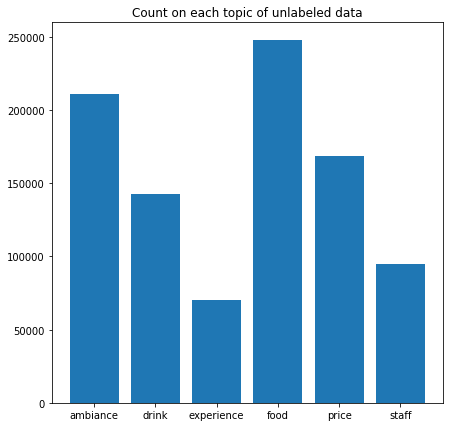

In [0]:
plt.figure(figsize = (7,7))
plt.bar(topic_summarize["aspect"], topic_summarize["token"])
plt.title('Count on each topic of unlabeled data')
plt.show()

In [0]:
unlabeled_df_split_asp[unlabeled_df_split_asp["aspect"] == 'staff']


,id,sentence,token,aspect,token_no_stop_word
6,0,phục_vụ niềm_nở chào_đón và phục_vụ chu_đáo,"[phục_vụ, niềm_nở, chào_đón, và, phục_vụ, chu_đáo]",staff,"[phục_vụ, niềm_nở, chào_đón, phục_vụ, chu_đáo]"
8,0,phải nói là rất hài_lòng vì thịt mềm và juicy lắm,"[phải, nói, là, rất, hài_lòng, vì, thịt, mềm, và, juicy, lắm]",staff,"[nói, hài_lòng, thịt, mềm, juicy]"
9,0,thêm cái khoản tendeloin nên bò mềm phải_biết nha,"[thêm, cái, khoản, tendeloin, nên, bò, mềm, phải_biết, nha]",staff,"[thêm, khoản, tendeloin, bò, mềm, phải_biết, nha]"
13,1,giữ xe rất nhiệt_tình,"[giữ, xe, rất, nhiệt_tình]",staff,"[giữ, xe, nhiệt_tình]"
18,1,vì cúp điện nên nhân_viên đốt nến,"[vì, cúp, điện, nên, nhân_viên, đốt, nến]",staff,"[cúp, điện, nhân_viên, đốt, nến]"
73,8,mấy anh nv ở đây rất vui_vẻ và tận_tình,"[mấy, anh, nv, ở, đây, rất, vui_vẻ, và, tận_tình]",staff,"[mấy, anh, nv, ở, vui_vẻ, tận_tình]"
76,9,nhân_viên nhiệt_tình nữa,"[nhân_viên, nhiệt_tình, nữa]",staff,"[nhân_viên, nhiệt_tình]"
92,12,phục_vụ nhanh lẹ chắc mình đi buổi trưa nên không có ai cho kèm chén súp ok lắm,"[phục_vụ, nhanh, lẹ, chắc, mình, đi, buổi, trưa, nên, không, có, ai, cho, kèm, chén, súp, ok, lắm]",staff,"[phục_vụ, nhanh, lẹ, chắc, đi, buổi, trưa, ai, kèm, chén, súp, ok]"
106,14,quán không có điều_hoà nóng,"[quán, không, có, điều_hoà, nóng]",staff,"[quán, điều_hoà, nóng]"
113,15,nhân_viên thì nhiệt_tình và dễ_thương,"[nhân_viên, thì, nhiệt_tình, và, dễ_thương]",staff,"[nhân_viên, nhiệt_tình, dễ_thương]"


In [0]:
ViPosTagger.postagging('xen_kẽ là lớp bánh brownie')

(['xen_kẽ', 'là', 'lớp', 'bánh', 'brownie'], ['V', 'V', 'N', 'N', 'A'])